<a href="https://colab.research.google.com/github/pascalghanimi/Ski-Classification-AI/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pickle
from glob import glob
files = glob("*_features.pkl")

with open(files[0], "rb") as f:
  test_file = pickle.load(f)


# features_with_labels beinhaltet fahrstil, schwung_labels, COM_to_ground, knee_angles_right, knee_angles_left, joint_angles, axis_angles, COM_angles
# fahrstil beinhaltet einen einzigen Wert, z.B. EKK -> Wert (einfach ein Wert)
# schwung_labels beinhalten für jeden Frame den Schwung, also Rechts oder Linksschwung (1 Linksschwung, 2 Rechtsschwung) Frame: Wert
# COM_to_ground beinhaltet für jeden Frame den Abstand zwischen COM und Boden Frame: Wert
# knee_angles_right und knee_angles_left beinhalten für jeden Frame die Kniewinkel (also Winkel zwischen Oberschenkel und Unterschenkel) -> Frame: Wert
# joint_angles gibt die Winkel zwischen den Segmenten (z.B. Oberarm, genannt shoulder to ellbow) und den 3 Achsen (x, y und z) -> Frame: { Achse: { Obarm links, Oberschenkel links, etc.}}
# axis_angles gibt die Winkel der Achsen (z.B. Schulterachse, Hüftachse, etc.) zu den 3 Achsen (x, y und z) -> Frame: { Achse: { Schulterachse, Hüftachse }}
# COM_angles gibt Winkel zwischen dem Vektor Boden zu COM und den 3 Achsen (x, y und z) -> Frame: {x-Winkel, y-Winkel, z-Winkel}
print("Fahrstil", test_file["fahrstil"])
print("Schwung Label (rechts oder links)", test_file["schwung_labels"])
print("COM zum Boden Abstand", test_file["COM_to_ground"])
print("Kniewinkel rechts", test_file["knee_angles_right"])
print("Winkel zwischen Segmenten und Achsen", test_file["joint_angles"])
print("Winkel zwischen Körperchsen (z.B. Schulterachse) und Achsen", test_file["axis_angles"])
print("Winkel zwischen Vektor Boden zum COM und den 3 Achsen", test_file["COM_angles"])

Fahrstil PGK
Schwung Label (rechts oder links) {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 2, 103: 2, 104: 2, 105: 2, 106: 2, 107: 2, 108: 2, 109: 2, 110: 2, 111: 2, 112: 2, 113: 2, 114: 2, 115: 2, 116: 2, 117: 2, 118: 2, 119: 2, 120: 2, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 2, 129: 2, 130: 2, 131: 2, 132: 2

In [51]:
print("Keys", test_file.keys())
print("Anzahl der Datenpunkte/Frames", len(test_file["knee_angles_right"]))

Keys dict_keys(['COM_to_ground', 'knee_angles_right', 'knee_angles_left', 'joint_angles', 'axis_angles', 'COM_angles', 'schwung_labels', 'fahrstil'])
Anzahl der Datenpunkte/Frames 247


In [52]:
for key in test_file["schwung_labels"]:
  if (key == 0):
    print(test_file["COM_to_ground"][key])
    print(test_file["knee_angles_right"][key])
    print(test_file["knee_angles_left"][key])
    for axis in test_file["joint_angles"][key]:
      print(test_file["joint_angles"][key][axis].values())

    for axis in test_file["axis_angles"][key]:
      print(test_file["axis_angles"][key][axis].values())

    print(test_file["COM_angles"][key].values())

0.71407366
93.98422
93.7224
dict_values([np.float64(69.64585889255609), np.float64(105.659070172074), np.float64(108.66648334046101), np.float64(121.9207188325632), np.float64(50.50165712949768), np.float64(51.394611461122956)])
dict_values([np.float64(45.178775718324324), np.float64(17.82393023599096), np.float64(54.909886571210194), np.float64(54.75147233068241), np.float64(41.93969967009637), np.float64(39.037757357768335)])
dict_values([np.float64(128.1829794414039), np.float64(81.6997070238625), np.float64(138.85581051492997), np.float64(128.4901002259286), np.float64(78.15665912681365), np.float64(85.07469685250508)])
dict_values([np.float64(47.553379578398626), np.float64(48.80640253458033), np.float64(42.412871512436965), np.float64(32.75439117440529)])
dict_values([np.float64(109.56952070670191), np.float64(110.46743873024668), np.float64(100.52795564279278), np.float64(105.64242856567486)])
dict_values([np.float64(48.89005784588529), np.float64(48.21725149295295), np.float64(

In [53]:
import numpy as np

# ich speichere die Werte in den Arrays, die y-Werte sind ein einfacher Array der Struktur [1, 2, 1, 1, 2], welcher für jeden Input Vektor den Output (Links- oder Rechtsschwung) ausgibt
# die data beinhaltet Unterarrays, die jeweils einen Wert für jedes Feature beinhalten, jeder Unterarray entspricht einem Frame
#  -> [[Frame 1 Feature 1, Frame 1 Feature 2, Frame 1, Feature 2], [Frame 2 Feature 1, Frame 2 Feature 2...], [ hier Werte dritter Frame alle Feature], ...]

data = []
labels = []
fahrstil_labels = []

MAX_LENGTH = 400

def augment_sequence(seq, noise_std=0.005, jitter_std=0.001, warp_strength=0.1, shift_max=10):
    seq = np.array(seq)

    # 0. Time Shift (zufällige Verschiebung nach vorn oder hinten)
    shift = np.random.randint(-shift_max, shift_max + 1)
    if shift > 0:
        seq = np.pad(seq, ((shift, 0), (0, 0)), mode='constant')[:len(seq)]
    elif shift < 0:
        seq = np.pad(seq, ((0, -shift), (0, 0)), mode='constant')[-shift:]
    # shift == 0 → bleibt unverändert

    # 1. Noise Injection
    seq += np.random.normal(0, noise_std, seq.shape)

    # 2. Jittering (feines zufälliges Zucken)
    seq += np.random.normal(0, jitter_std, seq.shape)

    # 3. Time Warping
    stretch_factor = 1 + np.random.uniform(-warp_strength, warp_strength)
    t_original = np.linspace(0, 1, len(seq))
    t_warped = np.linspace(0, 1, int(len(seq) * stretch_factor))
    warped = np.array([
        np.interp(t_original, np.clip(t_warped, 0, 1),
                  np.interp(t_warped, np.linspace(0, 1, len(seq)), seq[:, i]))
        for i in range(seq.shape[1])
    ]).T

    # Länge anpassen
    warped = warped[:len(seq)] if warped.shape[0] >= len(seq) else np.pad(warped, ((0, len(seq) - warped.shape[0]), (0, 0)))
    return warped



for file in files:
    with open(file, "rb") as f:
        features = pickle.load(f)

    sequence_data = []
    sequence_labels = []

    # Extrahiere Features für jeden Frame
    for frame_idx in features["schwung_labels"]:
        try:
            frame_features = [
                features["COM_to_ground"][frame_idx],
                features["knee_angles_right"][frame_idx],
                features["knee_angles_left"][frame_idx]
            ]

            # Füge joint_angles hinzu
            for axis in features["joint_angles"][frame_idx]:
                frame_features.extend(features["joint_angles"][frame_idx][axis].values())

            # Füge axis_angles hinzu
            for axis in features["axis_angles"][frame_idx]:
                frame_features.extend(features["axis_angles"][frame_idx][axis].values())

            # Füge COM_angles hinzu
            frame_features.extend(features["COM_angles"][frame_idx].values())

            sequence_data.append(frame_features)
            sequence_labels.append(features["schwung_labels"][frame_idx])

        except KeyError as e:
            print(f"Fehler in Datei {file}, Frame {frame_idx}: {str(e)}")
            break

    # Padding für zu kurze Sequenzen
    if len(sequence_data) < MAX_LENGTH:
        pad_length = MAX_LENGTH - len(sequence_data)
        pad_features = [0] * len(sequence_data[0]) if sequence_data else [0] * 27  # Annahme: 27 Features
        sequence_data += [pad_features] * pad_length
        sequence_labels += [0] * pad_length

    data.append(sequence_data)
    labels.append(sequence_labels)

    # Fahrstil vereinheitlichen
    vereinheitlicht = features["fahrstil"].replace("2", "")
    fahrstil_labels.append(vereinheitlicht)



# Konvertiere zu NumPy-Arrays
data = np.array(data, dtype=np.float32)
fahrstil_labels = np.array(fahrstil_labels)

print (data)
print(data[0])

[[[  0.71407366  93.98422     93.7224     ... 111.6815     156.40187
    98.867905  ]
  [  0.73982906  99.143684   100.00918    ... 110.63613    157.70102
    98.08213   ]
  [  0.7622128  104.27026    106.54143    ... 109.562874   159.5715
    95.65484   ]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]

 [[  0.78327453 109.79506    109.34889    ... 104.62353    162.44833
    99.49324   ]
  [  0.77764195 109.43027    106.848526   ... 104.27544    162.3725
   100.124435  ]
  [  0.77943057 110.32319    107.055435   ... 103.91977    163.36458
    98.92822   ]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
   

In [54]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter



# ------------------- Datenvorbereitung -------------------
# 1. Label Encoding für Fahrstile
le = LabelEncoder()
fahrstil_encoded = le.fit_transform(fahrstil_labels)

# 2. Daten-Normalisierung
scaler = StandardScaler()
original_shape = data.shape

# Skalierung durchführen
data_normalized = scaler.fit_transform(data.reshape(-1, data.shape[-1]))  # Flatten zu 2D
data_normalized = data_normalized.reshape(original_shape)  # Zurück zu 3D

with open("scaler_schwung.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("encoder_schwung.pkl", "wb") as f:
    pickle.dump(le, f)


# 3. Stratifizierte Train/Val/Test Split
X_train, X_temp, Y_train, Y_temp = train_test_split(
    data_normalized,
    fahrstil_encoded,
    test_size=0.3,
    stratify=fahrstil_encoded,
    random_state=42
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp,
    Y_temp,
    test_size=0.5,
    stratify=Y_temp,
    random_state=42
)

# ✅ 👉 HIER Augmentierung NUR für das Trainingsset
# X_train_aug = np.array([augment_sequence(x) for x in X_train])
# Y_train_aug = Y_train.copy()

label_counts = Counter(Y_train)
median_count = np.median(list(label_counts.values()))

X_aug = []
Y_aug = []

# for x, y in zip(X_train, Y_train):

#      for _ in range(3):  # 3x Augmentierung pro Sample der Minderheitsklasse
#        x_aug = augment_sequence(x)
#        X_aug.append(x_aug)
#        Y_aug.append(y)




# ─── 4. Kombiniere Original + augmentierte Daten ───────────────────────────────
if len(X_aug) > 0:
    # Augmentierte Sequenzen als 3D-Array (n_samples, seq_len, feat_dim)
    X_aug_arr = np.array(X_aug, dtype=np.float32)
    Y_aug_arr = np.array(Y_aug, dtype=np.int64)
    X_train_combined = np.concatenate([X_train, X_aug_arr], axis=0)
    Y_train_combined = np.concatenate([Y_train, Y_aug_arr], axis=0)
else:
    # Keine Augmentierung → nur Originaldaten
    X_train_combined = X_train
    Y_train_combined = Y_train










# 5. Konvertierung zu PyTorch Tensoren (KORRIGIERT)
X_train = torch.tensor(X_train_combined, dtype=torch.float32)
Y_train = torch.tensor(Y_train_combined, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)


# ------------------- DataLoader -------------------
batch_size = 16
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler, DataLoader, TensorDataset
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

# ─── Daten in Tensoren konvertieren (korrekte Methode) ─────────────────────────
X_train = torch.as_tensor(X_train).float()
Y_train = torch.as_tensor(Y_train).long()
X_val = torch.as_tensor(X_val).float()
Y_val = torch.as_tensor(Y_val).long()
X_test = torch.as_tensor(X_test).float()
Y_test = torch.as_tensor(Y_test).long()

# ─── TensorDatasets ───────────────────────────────────────────────────────────
train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val, Y_val)
test_dataset  = TensorDataset(X_test, Y_test)

# ─── Klassen-Gewichte und Sampler ─────────────────────────────────────────────
num_classes = len(le.classes_)
class_names = le.classes_

# Klassen-Gewichte berechnen
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=Y_train.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Sampler für balanciertes Training
sample_weights = class_weights[Y_train.numpy()]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ─── DataLoaders ──────────────────────────────────────────────────────────────
batch_size = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    drop_last=True
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ─── Modellarchitektur mit korrigierter Attention ─────────────────────────────
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Eingangsdimension: (hidden_size * 2) + (hidden_size * 2) = hidden_size * 4
        self.attn = nn.Linear(hidden_size * 4, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, outputs):
        # hidden: [batch, hidden_size*2]
        # outputs: [batch, seq_len, hidden_size*2]
        hidden = hidden.unsqueeze(1).repeat(1, outputs.size(1), 1)  # [batch, seq_len, hidden_size*2]
        combined = torch.cat((hidden, outputs), dim=2)  # [batch, seq_len, hidden_size*4]
        energy = torch.tanh(self.attn(combined))  # [batch, seq_len, hidden_size]
        attention = torch.softmax(self.v(energy).squeeze(2), dim=1)  # [batch, seq_len]
        return torch.sum(attention.unsqueeze(2) * outputs, dim=1)  # [batch, hidden_size*2]

class SkiSwingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.4
        )
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        outputs, (hidden, _) = self.lstm(x)
        # Kombiniere die letzten Hidden States beider Richtungen
        hidden_combined = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [batch, hidden_size*2]
        context = self.attention(hidden_combined, outputs)
        return self.fc(self.dropout(context))

# ─── Focal Loss ────────────────────────────────────────────────────────────────
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss

        if self.alpha is not None:
            alpha_weights = self.alpha[targets]
            return torch.mean(alpha_weights * focal_loss)
        return torch.mean(focal_loss)

# ─── Training Setup ───────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkiSwingLSTM(
    input_size=X_train.shape[2],  # Anzahl Features pro Zeitschritt
    hidden_size=128,  # Reduziert für bessere Stabilität
    num_classes=num_classes
).to(device)

# Klassen-Gewichte für Focal Loss
class_weights = class_weights.to(device)
loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=False  # Warnung deaktiviert
)

# Finde Klassenindizes für spezifisches Monitoring
class_idx_ekk = np.where(class_names == 'EKK')[0][0]
class_idx_pdk = np.where(class_names == 'PDK')[0][0]

# ─── Training ─────────────────────────────────────────────────────────────────
best_val_f1 = 0.0
patience = 30
patience_counter = 0

for epoch in range(1, 301):
    # Training
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(batch_y.cpu().numpy())

    # Berechne Metriken
    val_accuracy = np.mean(np.array(val_preds) == np.array(val_true))
    val_f1_ekk = f1_score(val_true, val_preds, labels=[class_idx_ekk], average='macro', zero_division=0)
    val_f1_pdk = f1_score(val_true, val_preds, labels=[class_idx_pdk], average='macro', zero_division=0)
    val_f1_mean = (val_f1_ekk + val_f1_pdk) / 2

    print(f"Epoch {epoch:3d} | Loss: {total_loss/len(train_loader):.4f} | "
          f"Val Acc: {val_accuracy:.4f} | EKK F1: {val_f1_ekk:.4f} | PDK F1: {val_f1_pdk:.4f}")

    # Scheduler und Early Stopping
    scheduler.step(val_f1_mean)

    if val_f1_mean > best_val_f1:
        best_val_f1 = val_f1_mean
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early Stopping nach {epoch} Epochen")
            break

# ─── Evaluation ────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(batch_y.cpu().numpy())

print("\nKlassifikationsbericht:")
print(classification_report(
    all_true,
    all_preds,
    labels=range(num_classes),
    target_names=class_names,
    zero_division=0
))

# Spezifische Metriken für EKK/PDK
print("\nSpezifische Klassen-Metriken:")
ekk_mask = np.array(all_true) == class_idx_ekk
pdk_mask = np.array(all_true) == class_idx_pdk

ekk_precision = np.mean(np.array(all_preds)[ekk_mask] == class_idx_ekk) if np.any(ekk_mask) else 0
pdk_precision = np.mean(np.array(all_preds)[pdk_mask] == class_idx_pdk) if np.any(pdk_mask) else 0

print(f"EKK Precision: {ekk_precision:.4f}")
print(f"PDK Precision: {pdk_precision:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1 | Loss: 1.5436 | Val Acc: 0.2358 | EKK F1: 0.2041 | PDK F1: 0.2353
Epoch   2 | Loss: 1.0842 | Val Acc: 0.2642 | EKK F1: 0.3158 | PDK F1: 0.4571
Epoch   3 | Loss: 1.0488 | Val Acc: 0.2925 | EKK F1: 0.4314 | PDK F1: 0.0000
Epoch   4 | Loss: 0.8911 | Val Acc: 0.4151 | EKK F1: 0.4211 | PDK F1: 0.1000
Epoch   5 | Loss: 0.7080 | Val Acc: 0.4623 | EKK F1: 0.4138 | PDK F1: 0.4167
Epoch   6 | Loss: 0.7230 | Val Acc: 0.3679 | EKK F1: 0.4242 | PDK F1: 0.4375
Epoch   7 | Loss: 0.6757 | Val Acc: 0.3679 | EKK F1: 0.4242 | PDK F1: 0.5333
Epoch   8 | Loss: 0.6311 | Val Acc: 0.4906 | EKK F1: 0.6286 | PDK F1: 0.2857
Epoch   9 | Loss: 0.6060 | Val Acc: 0.5472 | EKK F1: 0.6897 | PDK F1: 0.4545
Epoch  10 | Loss: 0.4674 | Val Acc: 0.4528 | EKK F1: 0.4000 | PDK F1: 0.5294
Epoch  11 | Loss: 0.4888 | Val Acc: 0.6792 | EKK F1: 0.6875 | PDK F1: 0.3529
Epoch  12 | Loss: 0.4318 | Val Acc: 0.5566 | EKK F1: 0.6957 | PDK F1: 0.6154
Epoch  13 | Loss: 0.4600 | Val Acc: 0.6321 | EKK F1: 0.6667 | PDK F1: 0.6667

✔️ Gefundene Feature-Namen: 36 Stück
✔️ Feature-Matrix: 143393 Zeilen × 36 Spalten
🔔 Insgesamt 36 Features


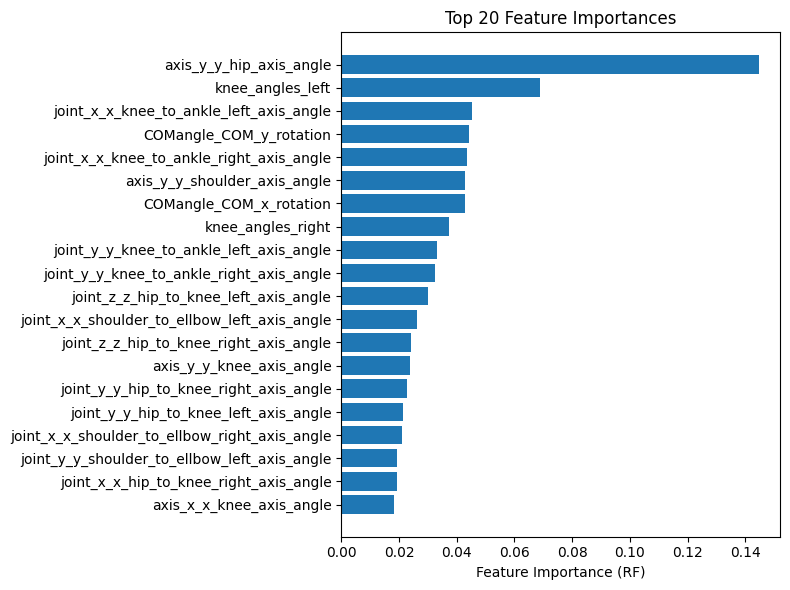

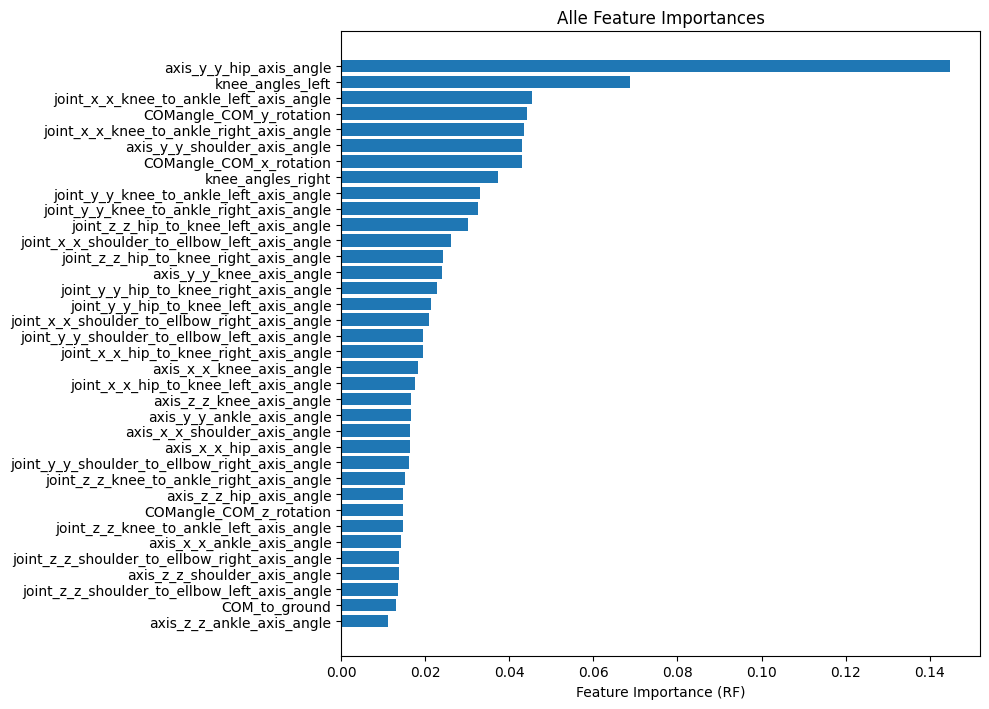

In [56]:
# ── Cell A: Roh-Features + Namen extrahieren ─────────────────────────────────

import pickle
from glob import glob
import numpy as np

# 1) Sample laden, um Feature-Namen zu erzeugen
feat_files = glob("*_features.pkl")
with open(feat_files[0], "rb") as f:
    sample = pickle.load(f)

# 2) Feature-Namen in der korrekten Reihenfolge bauen
feat_names = ["COM_to_ground", "knee_angles_right", "knee_angles_left"]
first_frame = next(iter(sample["COM_to_ground"].keys()))

# joint_angles
for axis, joints in sample["joint_angles"][first_frame].items():
    for j in joints.keys():
        feat_names.append(f"joint_{axis}_{j}")

# axis_angles
for coord_axis, bodys in sample["axis_angles"][first_frame].items():
    for ba in bodys.keys():
        feat_names.append(f"axis_{coord_axis}_{ba}")

# COM_angles
for ca in sample["COM_angles"][first_frame].keys():
    feat_names.append(f"COMangle_{ca}")

print(f"✔️ Gefundene Feature-Namen: {len(feat_names)} Stück")

# 3) Alle Frames über alle Files einsammeln
X = []
y = []
for fn in feat_files:
    with open(fn, "rb") as f:
        fe = pickle.load(f)
    for frm, swing in fe["schwung_labels"].items():
        row = [
            fe["COM_to_ground"][frm],
            fe["knee_angles_right"][frm],
            fe["knee_angles_left"][frm],
        ]
        # joint_angles
        for axis in fe["joint_angles"][frm]:
            row += list(fe["joint_angles"][frm][axis].values())
        # axis_angles
        for coord in fe["axis_angles"][frm]:
            row += list(fe["axis_angles"][frm][coord].values())
        # COM_angles
        row += list(fe["COM_angles"][frm].values())

        X.append(row)
        y.append(swing)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=int)

assert X.shape[1] == len(feat_names), f"{X.shape[1]} vs {len(feat_names)}"
print(f"✔️ Feature-Matrix: {X.shape[0]} Zeilen × {X.shape[1]} Spalten")

# ── Cell B: RandomForest trainieren & Feature Importances plotten ────────────

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# 1) RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 2) DataFrame mit Importances
df_imp = pd.DataFrame({
    "feature": feat_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

# 3) Anzahl ausgeben
print(f"🔔 Insgesamt {len(feat_names)} Features")

# 4) Top 20 plotten
topn = 20
df_top = df_imp.head(topn)

plt.figure(figsize=(8,6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature Importance (RF)")
plt.title(f"Top {topn} Feature Importances")
plt.tight_layout()
plt.show()

# 5) Alle Features (falls du willst)
plt.figure(figsize=(10, len(df_imp)*0.2))
plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
plt.xlabel("Feature Importance (RF)")
plt.title("Alle Feature Importances")
plt.tight_layout()
plt.show()


Confusion Matrix (counts):
[[17  0  0  2  2  0  0  0]
 [ 0  7  0  3  0  0  0  0]
 [ 0  0  6  0  0  0  0  2]
 [ 0  1  0 13  0  0  0  0]
 [ 1  2  0  0 11  0  0  0]
 [ 0  0  0  0  0  9  0  1]
 [ 0  0  0  0  0  9  3  4]
 [ 0  0  0  0  0  5  0  8]]


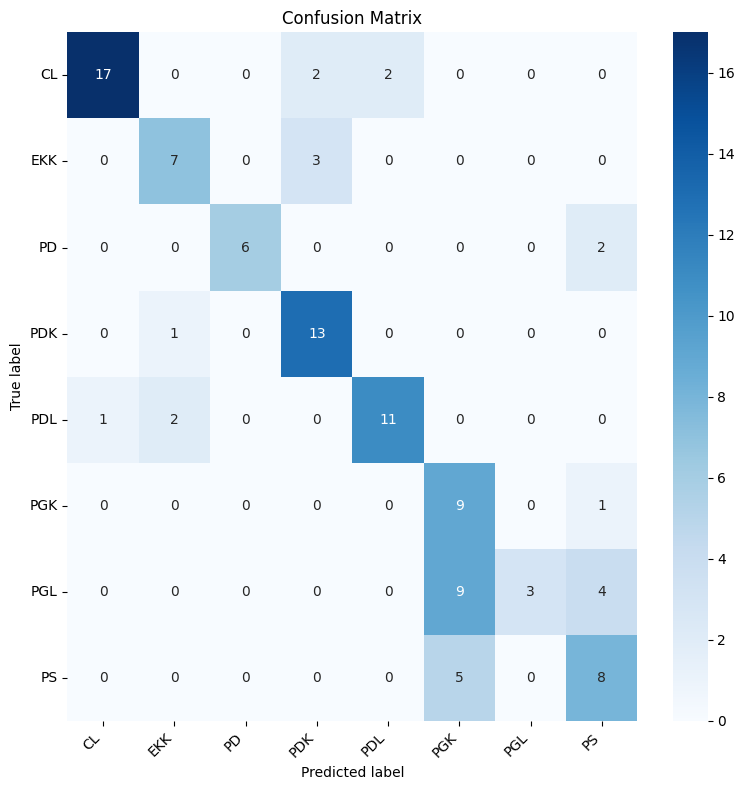

In [57]:
# ── Cell 1: Confusion Matrix (counts) berechnen ────────────────────────────────
from sklearn.metrics import confusion_matrix
import numpy as np

# all_true, all_preds und class_names sollten schon definiert sein
# z.B. all_true = np.array(all_true); all_preds = np.array(all_preds)
# class_names = le.classes_

# 1) Confusion Matrix (counts)
cm = confusion_matrix(all_true, all_preds, labels=np.arange(len(class_names)))
print("Confusion Matrix (counts):")
print(cm)

# ── Cell 2: Confusion Matrix plotten ─────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [58]:
print(le.classes_)


['CL' 'EKK' 'PD' 'PDK' 'PDL' 'PGK' 'PGL' 'PS']


In [59]:
torch.save(model, "ski_schwung_classifier.pt")

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(
    data,
    labels,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp,
    Y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)


In [61]:
data = []
labels = []
fahrstil_labels = []

# Fahrstile vorher encodieren
fahrstile_raw = [pickle.load(open(f, "rb"))["fahrstil"] for f in files]
le = LabelEncoder()
le.fit(fahrstile_raw)

for file in files:
    with open(file, "rb") as f:
        features = pickle.load(f)

    sequence_data = []
    sequence_labels = []

    fahrstil_encoded = le.transform([features["fahrstil"]])[0]  # als Zahl

    for frame_idx in features["schwung_labels"]:
        try:
            frame_features = [
                features["COM_to_ground"][frame_idx],
                features["knee_angles_right"][frame_idx],
                features["knee_angles_left"][frame_idx]
            ]

            for axis in features["joint_angles"][frame_idx]:
                frame_features.extend(features["joint_angles"][frame_idx][axis].values())

            for axis in features["axis_angles"][frame_idx]:
                frame_features.extend(features["axis_angles"][frame_idx][axis].values())

            frame_features.extend(features["COM_angles"][frame_idx].values())

            frame_features.append(fahrstil_encoded)  # Fahrstil konstant pro Frame

            sequence_data.append(frame_features)
            sequence_labels.append(features["schwung_labels"][frame_idx])

        except KeyError as e:
            print(f"Fehler in Datei {file}, Frame {frame_idx}: {str(e)}")
            break

    if len(sequence_data) < MAX_LENGTH:
        pad_len = MAX_LENGTH - len(sequence_data)
        pad_feat = [0] * len(sequence_data[0]) if sequence_data else [0] * 28
        sequence_data += [pad_feat] * pad_len
        sequence_labels += [0] * pad_len

    data.append(sequence_data)
    labels.append(sequence_labels)
    fahrstil_labels.append(fahrstil_encoded)


In [62]:
data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

X_train, X_temp, Y_train, Y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=16)
test_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=16)



In [63]:
class FrameWiseLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_size * 2, num_classes)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    return self.fc(self.dropout(lstm_out))

device = torch.device("cuda" if torch.cuda.is_available() else "cpi")
model = FrameWiseLSTM(input_size=data.shape[-1], hidden_size=128, num_classes=3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_accuracy = 0
patience = 30
patience_counter = 0

for epoch in range(100):
  model.train()
  for batch_x, batch_y in train_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_x)
    output = output.permute(0, 2, 1)
    loss = loss_fn(output, batch_y)
    loss.backward()
    optimizer.step()

  model.eval()
  val_preds = []
  val_true = []
  with torch.no_grad():
    for batch_x, batch_y in val_loader:
      batch_x = batch_x.to(device)
      preds = model(batch_x).argmax(dim=-1).cpu()
      val_preds.append(preds)
      val_true.append(batch_y)




  val_preds = torch.cat(val_preds).flatten().numpy()
  val_true = torch.cat(val_true).flatten().numpy()

  # ❗ Padding rausfiltern (0 = kein echtes Label)
  mask = val_true != 0
  val_accuracy = np.mean(val_preds[mask] == val_true[mask])

  print(f"Epoch {epoch+1:3d} | Val Accuracy: {val_accuracy:.4f}")


  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    patience_counter = 0
    torch.save(model.state_dict(), "best_model_framewise.pth")
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early Stopping at Epoch {epoch + 1}")
      break;


model.load_state_dict(torch.load("best_model_framewise.pth"))
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
  for batch_x, batch_y in test_loader:
    batch_x = batch_x.to(device)
    preds = model(batch_x).argmax(dim=-1).cpu()
    all_preds.append(preds)
    all_true.append(batch_y)

all_preds = torch.cat(all_preds).flatten().numpy()
all_true = torch.cat(all_true).flatten().numpy()

# ❗ Nur echte Labels vergleichen
mask = all_true != 0
print("\nKlassifikationsbericht:")
print(classification_report(all_true[mask], all_preds[mask], digits=3, zero_division=0))

Epoch   1 | Val Accuracy: 0.8724
Epoch   2 | Val Accuracy: 0.8935
Epoch   3 | Val Accuracy: 0.8929
Epoch   4 | Val Accuracy: 0.8986
Epoch   5 | Val Accuracy: 0.9026
Epoch   6 | Val Accuracy: 0.9012
Epoch   7 | Val Accuracy: 0.9139
Epoch   8 | Val Accuracy: 0.9201
Epoch   9 | Val Accuracy: 0.9155
Epoch  10 | Val Accuracy: 0.9160
Epoch  11 | Val Accuracy: 0.9239
Epoch  12 | Val Accuracy: 0.9088
Epoch  13 | Val Accuracy: 0.9016
Epoch  14 | Val Accuracy: 0.9199
Epoch  15 | Val Accuracy: 0.8986
Epoch  16 | Val Accuracy: 0.9335
Epoch  17 | Val Accuracy: 0.9166
Epoch  18 | Val Accuracy: 0.9213
Epoch  19 | Val Accuracy: 0.9071
Epoch  20 | Val Accuracy: 0.9171
Epoch  21 | Val Accuracy: 0.8996
Epoch  22 | Val Accuracy: 0.9266
Epoch  23 | Val Accuracy: 0.8363
Epoch  24 | Val Accuracy: 0.9166
Epoch  25 | Val Accuracy: 0.9116
Epoch  26 | Val Accuracy: 0.9256
Epoch  27 | Val Accuracy: 0.9165
Epoch  28 | Val Accuracy: 0.9294
Epoch  29 | Val Accuracy: 0.9282
Epoch  30 | Val Accuracy: 0.8867
Epoch  31 

🔔 Verwendete Features: 37, Samples: 143393
🔔 Insgesamt 37 Features


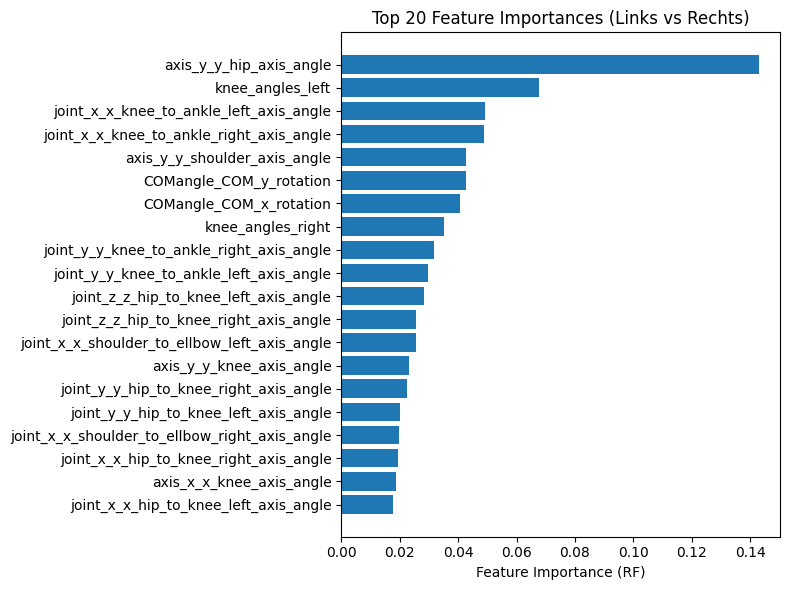

In [65]:
# ── Cell A: Feature Importances für Links-Rechts Klassifikator ────────────────
import pickle, numpy as np, pandas as pd
from glob import glob
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1) Feature-Namen aus Sample reproduzieren (wie in Cell A zuvor) + Style-Index
feat_files = glob("*_features.pkl")
with open(feat_files[0], "rb") as f:
    sample = pickle.load(f)

feat_names = ["COM_to_ground", "knee_angles_right", "knee_angles_left"]
first_frame = next(iter(sample["COM_to_ground"].keys()))

for axis, joints in sample["joint_angles"][first_frame].items():
    for j in joints:
        feat_names.append(f"joint_{axis}_{j}")

for coord, bodys in sample["axis_angles"][first_frame].items():
    for ba in bodys:
        feat_names.append(f"axis_{coord}_{ba}")

for ca in sample["COM_angles"][first_frame].keys():
    feat_names.append(f"COMangle_{ca}")

# zusätzlich das konstante Style-Feature
feat_names.append("style_idx")

# 2) Daten flach machen
#    data: shape (n_samples, seq_len, feat_dim), labels: (n_samples, seq_len)
X = np.array(data, dtype=np.float32).reshape(-1, data.shape[-1])
y = np.array(labels, dtype=int).flatten()
mask = (y != 0)  # Padding-Frames (Label 0) rausfiltern
X, y = X[mask], y[mask]

print(f"🔔 Verwendete Features: {len(feat_names)}, Samples: {X.shape[0]}")

# 3) RandomForest trainieren
rf_lr = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_lr.fit(X, y)

# 4) Feature Importances in DataFrame sortieren
df_imp_lr = pd.DataFrame({
    "feature": feat_names,
    "importance": rf_lr.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(f"🔔 Insgesamt {len(feat_names)} Features")

# 5) Top-20 plotten
topn = 20
df_top_lr = df_imp_lr.head(topn)

plt.figure(figsize=(8,6))
plt.barh(df_top_lr["feature"][::-1], df_top_lr["importance"][::-1])
plt.xlabel("Feature Importance (RF)")
plt.title(f"Top {topn} Feature Importances (Links vs Rechts)")
plt.tight_layout()
plt.show()


Confusion Matrix (counts):
[[10782   554]
 [  719  9730]]


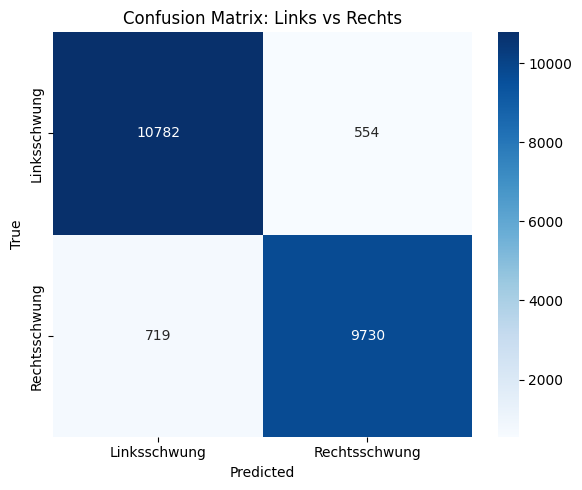

In [68]:
# ── Cell B: Confusion Matrix für Links-Rechts Klassifikator ──────────────────
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Neue Maske nur für das Testset
all_true_arr = np.array(all_true).flatten()
all_pred_arr = np.array(all_preds).flatten()
mask_lr = (all_true_arr != 0)         # Alle echten (nicht-gepadeten) Frames

y_true = all_true_arr[mask_lr]
y_pred = all_pred_arr[mask_lr]

# 2) Confusion Matrix zählen
cm_lr = confusion_matrix(y_true, y_pred, labels=[1,2])
print("Confusion Matrix (counts):")
print(cm_lr)

# 3) Plot
labels_lr = ["Linksschwung", "Rechtsschwung"]
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels_lr,
            yticklabels=labels_lr)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Links vs Rechts")
plt.tight_layout()
plt.show()


In [64]:
torch.save(model, "left_right_classifier.pt")